In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False,
}

In [2]:
import mlx.core as mx
import mlx.nn as nn

# LLM architecture

In [3]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(mx.arange(seq_len))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

    def __call__(self, x):
        return self.forward(x)
    
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
    def forward(self, x):
        return x
    def __call__(self, x):
        return self.forward(x)
    
class DummyLayerNorm(nn.Module):
    def __init__(self, cfg):
        super().__init__()
    def forward(self, x):
        return x
    def __call__(self, x):
        return self.forward(x)


In [4]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(mx.array(tokenizer.encode(txt1)))
batch.append(mx.array(tokenizer.encode(txt2)))
batch = mx.stack(batch, axis=0)
batch

array([[6109, 3626, 6100, 345],
       [6109, 1110, 6622, 257]], dtype=int32)

In [5]:
mx.random.seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
logits.shape, logits

((2, 4, 50257),
 array([[[0.0325858, -0.00327153, 0.0314474, ..., -0.05538, -0.0313719, 0.025868],
         [0.0114696, -0.0338207, 0.0420545, ..., 0.0776588, -0.0185897, 0.0412946],
         [0.0335977, 0.0204688, 0.0283034, ..., -0.00401974, -0.00234349, 0.0478059],
         [-0.0363127, -0.0260188, -0.0139646, ..., 0.0469502, 0.0119287, 0.00278975]],
        [[0.0372902, -0.00251749, 0.059333, ..., -0.03758, -0.0354561, 0.0315046],
         [-0.00316943, 0.00147293, 0.027029, ..., 0.00894648, -0.0558485, 0.0010028],
         [0.026175, -0.0170101, -0.00992603, ..., -0.00731882, 0.0446771, 0.0446581],
         [-0.00448758, -0.0576313, -0.0103115, ..., 0.0419662, -0.0424688, 0.0307011]]], dtype=float32))

# Normalizing activations with layernorm

In [6]:
mx.random.seed(123)
batch_example = mx.random.uniform(shape=(2, 5))
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
out

array([[0.245317, 0, 0, 0, 0, 0],
       [0.158271, 0, 0, 0.151647, 0, 0]], dtype=float32)

In [7]:
mean = out.mean(axis=-1, keepdims=True)
var = out.var(axis=-1, keepdims=True)
mean, var

(array([[0.0408861],
        [0.0516529]], dtype=float32),
 array([[0.00835838],
        [0.00533971]], dtype=float32))

In [8]:
out_norm = (out - mean) / mx.sqrt(var)
mean = out_norm.mean(axis=-1, keepdims=True)
var = out_norm.var(axis=-1, keepdims=True)
out_norm, mean, var

(array([[2.23607, -0.447214, -0.447214, -0.447214, -0.447214, -0.447214],
        [1.45905, -0.706865, -0.706865, 1.36841, -0.706865, -0.706865]], dtype=float32),
 array([[-3.97364e-08],
        [-1.98682e-08]], dtype=float32),
 array([[1],
        [1]], dtype=float32))

In [9]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = mx.ones(emb_dim)
        self.shift = mx.zeros(emb_dim)
    def forward(self, x):
        mean = x.mean(axis=-1, keepdims=True)
        var = x.var(axis=-1, keepdims=True)
        norm_x = (x - mean) / mx.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift
    def __call__(self, x):
        return self.forward(x)

In [10]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(axis=-1, keepdims=True)
var = out_ln.var(axis=-1, keepdims=True) #, unbiased=False): using n-1 denominator (Beseel's samling correction)
out_ln, mean, var

(array([[0.0143559, -0.317722, 1.90221, -0.768669, -0.830176],
        [-1.20911, 0.714974, 0.208862, -1.06962, 1.3549]], dtype=float32),
 array([[0],
        [1.90735e-07]], dtype=float32),
 array([[0.999921],
        [0.999318]], dtype=float32))

# Feedforward network with GELU activations

In [11]:
# nn.GELU
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 0.5 * x * (1 + mx.tanh(
            mx.sqrt(mx.array(2.0 / mx.pi)) * (x + 0.044715 * mx.power(x, 3))
        ))
    def __call__(self, x):
        return self.forward(x)

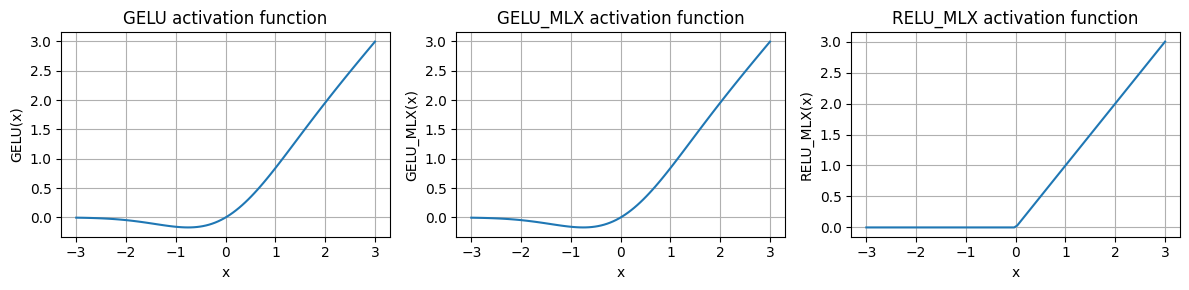

In [12]:
import matplotlib.pyplot as plt
gelu, gelu_nn, relu_nn = GELU(), nn.GELU(), nn.ReLU()
x = mx.linspace(-3, 3, 100)
y_gelu, y_gelu_nn, y_relu_nn = gelu(x), gelu_nn(x), relu_nn(x)

plt.figure(figsize=(12, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_gelu_nn, y_relu_nn], ["GELU", "GELU_MLX", "RELU_MLX"]), 1):
    plt.subplot(1, 3, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()

In [13]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            nn.GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        )
    def __call__(self, x):
        return self.layers(x)

In [14]:
ffn = FeedForward(GPT_CONFIG_124M)
x = mx.random.uniform(shape=(2, 3, 768))
out = ffn(x)
out, out.shape

(array([[[-0.0731656, -0.154929, 0.0142609, ..., 0.0422346, -0.169687, 0.17606],
         [-0.117855, -0.0929267, 0.0373913, ..., 0.000822926, -0.241744, 0.0752629],
         [-0.109236, -0.0940004, 0.104058, ..., 0.0416119, -0.108297, 0.122315]],
        [[-0.121868, -0.0783891, 0.0180716, ..., 0.0131748, -0.197627, 0.0740776],
         [-0.1666, -0.140969, 0.0873734, ..., 0.143977, -0.183883, 0.155529],
         [-0.04646, -0.0785241, 0.0343495, ..., 0.107342, -0.215675, 0.12396]]], dtype=float32),
 (2, 3, 768))

# Shortcut connections

In [ ]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = [
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), nn.GELU()),
        ]
    def __call__(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

def compute_mse_loss(model, x, target):
    # return mx.mean(mx.square(model(x) - target))
    ## using nn.losses.mse_loss
    return nn.losses.mse_loss(model(x), target)

def print_gradients(model, x):
    target = mx.array([[0.]])
    # same functionality for gradient
    # grad_fn = mx.grad(compute_mse_loss)
    # grad = grad_fn(model, x, target)
    loss, grad = mx.value_and_grad(compute_mse_loss)(model, x, target)
    # loss, grad = nn.value_and_grad(model, compute_mse_loss)(x, target)

    for i, outer_layer in enumerate(grad['layers']):
        # The structure has an inner 'layers' list
        for inner_layer_dict in outer_layer['layers']:
            if 'weight' in inner_layer_dict:
                weight_array = inner_layer_dict['weight']
                abs_mean_weight = weight_array.abs().mean().item()
                print(f"Layer {i+1} Weight Absolute Mean: {abs_mean_weight:.8f}")

            if 'bias' in inner_layer_dict:
                bias_array = inner_layer_dict['bias']
                abs_mean_bias = bias_array.abs().mean().item()
                print(f"Layer {i+1} Bias Absolute Mean:   {abs_mean_bias:.8f}")
            print("-" * 40)

In [16]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = mx.array([[1., 0., -1.]])

mx.random.seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)
print_gradients(model_without_shortcut, sample_input)

Layer 1 Weight Absolute Mean: 0.00000296
Layer 1 Bias Absolute Mean:   0.00000444
----------------------------------------
----------------------------------------
Layer 2 Weight Absolute Mean: 0.00000567
Layer 2 Bias Absolute Mean:   0.00004519
----------------------------------------
----------------------------------------
Layer 3 Weight Absolute Mean: 0.00003279
Layer 3 Bias Absolute Mean:   0.00021545
----------------------------------------
----------------------------------------
Layer 4 Weight Absolute Mean: 0.00015057
Layer 4 Bias Absolute Mean:   0.00092316
----------------------------------------
----------------------------------------
Layer 5 Weight Absolute Mean: 0.00091818
Layer 5 Bias Absolute Mean:   0.01063115
----------------------------------------
----------------------------------------


In [17]:
# shortcut connects prevent the gradients from vanishing in the early layers
mx.random.seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print_gradients(model_with_shortcut, sample_input)

Layer 1 Weight Absolute Mean: 0.01095946
Layer 1 Bias Absolute Mean:   0.01643919
----------------------------------------
----------------------------------------
Layer 2 Weight Absolute Mean: 0.02560675
Layer 2 Bias Absolute Mean:   0.03575864
----------------------------------------
----------------------------------------
Layer 3 Weight Absolute Mean: 0.00414518
Layer 3 Bias Absolute Mean:   0.00453086
----------------------------------------
----------------------------------------
Layer 4 Weight Absolute Mean: 0.00662550
Layer 4 Bias Absolute Mean:   0.00787471
----------------------------------------
----------------------------------------
Layer 5 Weight Absolute Mean: 0.11732697
Layer 5 Bias Absolute Mean:   0.16084231
----------------------------------------
----------------------------------------


# Connecting attention and linear layers in a transformer block

In [18]:
from previous_chapters import MultiHeadAttention

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    
    def __call__(self, x):
        # shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        # shortcut connection for feedforward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x


In [19]:
mx.random.seed(123)
x = mx.random.uniform(shape=(2, 4, 768))
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

x.shape, output.shape

((2, 4, 768), (2, 4, 768))

# GPT model

In [20]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])

        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg['n_layers'])])
        self.final_norm = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

    def __call__(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(mx.arange(seq_len))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [21]:
mx.random.seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
batch, out.shape, out

(array([[6109, 3626, 6100, 345],
        [6109, 1110, 6622, 257]], dtype=int32),
 (2, 4, 50257),
 array([[[0.976168, -0.65452, 0.708766, ..., -0.414631, -0.375584, -0.67339],
         [0.643055, -0.572836, 0.0752775, ..., 0.267556, -0.177602, -0.409495],
         [0.554118, -0.187771, 0.852581, ..., -0.293828, -0.973317, -0.485109],
         [-0.284444, -0.375543, 0.786829, ..., -0.210427, -0.56925, -1.03308]],
        [[0.484133, -0.435351, 1.73674, ..., -0.154704, 0.240796, -0.29407],
         [0.854106, -0.507258, 0.0458603, ..., 0.00086233, 0.647928, 0.117646],
         [0.0712366, -0.0251062, 0.83964, ..., 0.683549, 0.555009, -0.53265],
         [0.351332, -0.302475, 0.272237, ..., 0.47017, 0.491723, -0.308072]]], dtype=float32))

In [22]:
from mlx.utils import tree_flatten

total_params = sum(p.size for _, p in tree_flatten(model.parameters()))
print(f"Total parameters in the model: {total_params}")

Total parameters in the model: 213403392


# Generating text

In [23]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens)array of indices in the current context.
    for _ in range(max_new_tokens):
        # get current context within the context window
        idx_cond = idx[:, -context_size:]
        # get the predictions
        logits = model(mx.stop_gradient(idx_cond))
        # focus on the last time step
        logits = logits[:, -1, :]
        probas= mx.softmax(logits, axis=-1)
        # get the idx of the vocab entry with the highest probability
        idx_next = mx.argmax(probas, axis=-1, keepdims=True)
        # append sampled index to the sequence
        idx = mx.concat([idx, idx_next], axis=1)
    return idx
        

In [24]:
start_context = "Hell, I am"
encoded = tokenizer.encode(start_context)
encoded


[28254, 11, 314, 716]

In [25]:
encoded_tensor = mx.array(encoded)[None, :] # add batch dimension
encoded_tensor, encoded_tensor.shape

(array([[28254, 11, 314, 716]], dtype=int32), (1, 4))

In [26]:
model.eval()
out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)
out, len(out[0])

(array([[28254, 11, 314, ..., 11799, 26062, 36803]], dtype=int64), 10)

In [27]:
decoded_text = tokenizer.decode(out.squeeze().tolist())
decoded_text

'Hell, I am substant substant substantppers Debian Upload'